# Geodatenanalyse 1

## Tag 4 / Block 2 / Übung 12: Gauß-Prozesse

Diese Übung gibt eine kleine Einführung in die Interpolation mit Gauß-Prozessen mit `scikit-learn`. Die Dokumentation zu dem hier benutzten Python Package findet Ihr unter: https://scikit-learn.org/stable/modules/gaussian_process.html

Wir verwenden Gauß-Prozesse hier zur Vorhersage von Grundwassertemperaturen, basierend auf Messwerten an bestimmten Koordinaten (x, y), also zur räumlichen 2D Interpolation. Lest dazu wie in den letzten Übungen zuerst die Daten aus "interp_data.csv." ein. 

In [1]:
import pandas as pd
data = pd.read_csv('interp_data.csv', sep=';', encoding='cp1252')

`sklearn.gaussian_process` nimmt als Erwartungswertfunktion stets die Nullwert-Funktion an, daher müssen wir nur die Kovarianzfunktion definieren. Ladet zunächst aus der Library mit der Kovarianzfunktionen (in sklearn Kernels genannt) `sklearn.gaussian_process.kernels`, die Kernels `ConstantKernel` und `RBF`. 

Wir wollen die quadratische Exponentialfunktion aus der Vorlesung als Kovarianzfunktion nehmen, die jedoch in dem Package nicht vordefiniert ist. Wir können aber einen benutzerdefinierten Kernel erzeugen der diesem gleicht. Definiert dafür einen eigenen Kernel als Produkt aus einem `ConstantKernel()` mit "constant_value=1e2" (das entspricht dem Magnituden-Term), und einem `RBF()` Kernel mit einer "length_scale" von 150. 

Die Werte entsprechen ersten Abschätzungen aufgrund der Skalen von x und y, und sind Startwerte, die im Laufe der Gauß-Prozess Interpolation automatisch angepasst werden. 

In [2]:
from sklearn.gaussian_process.kernels import ConstantKernel, RBF

kernel = ConstantKernel(constant_value=1e2) * RBF(length_scale=150)

Ladet nun die Funktion `GaussianProcessRegressor()` aus `sklearn.gaussian_process` ein, und erstellt damit Gauß-Prozess Objekt.  

Dafür werden folgende Inputs angegeben: "normalize_y=True", da Daten noch nicht standardisiert sind, als "kernel" den oben definierten angeben. Zusätzlich "alpha=0.1" definieren. Dies addiert einen kleinen Fehlerterm zu den Werten in der Diagonalen der Kovarianzmatrix und dient der numerischen Stabilität während der Anpassung. 

Danach könnt Ihr über `Gauß-Objekt.fit()` die Anpassung (bzw. Interpolation) durchführen. Als Inputs die Stützstellen der Interpolation (die Koordinaten der Messstellen) als Arrays oder Listen angeben, und die zu interpolierenden Werte spezifizieren (Grundwassertemperaturen). 

Sklearn gibt automatisch nochmal die Details der Anpassungsfunktion (inkl. des benutzten Kernels) aus. 

In [3]:
from sklearn.gaussian_process import GaussianProcessRegressor

gp = GaussianProcessRegressor(normalize_y=True, alpha=0.1, kernel=kernel)
gp.fit(data[['Rechtswert', 'Hochwert']].values, data.GWT.values)


GaussianProcessRegressor(alpha=0.1, kernel=10**2 * RBF(length_scale=150),
                         normalize_y=True)

Jezt müsst Ihr noch analog zu vorhin wieder ein regelmäßiges Grid for x- und y-Koordinaten erzeugen, an denen die Vorhersage erfolgen soll. Dieses ebenfalls wieder in einen Array mit 2 Spalten umwandeln.  

In [4]:
import numpy as np
extent = x_min, x_max, y_min, y_max = [data.Rechtswert.min()-1000, data.Rechtswert.max()+1000,
                                       data.Hochwert.min()-1000, data.Hochwert.max()+1000]
grid_x, grid_y = np.mgrid[x_min:x_max:400, y_min:y_max:400]

X_grid = np.stack([grid_x.flatten(), grid_y.flatten()]).T

Nun könnt Ihr mit der Funktion `Gauß-Objekt.predict()` die Interpolation durchführen. Als Input wird hier nur das Grid benötigt.

Danach könnt Ihr den Output wieder in seine urspüngliche Dimensionen zurück formatieren, und graphisch darstellen. Stellt zum Vergleich wie vorhin auch die Inputdaten (Messwerte) an ihren Koordinaten dar. 

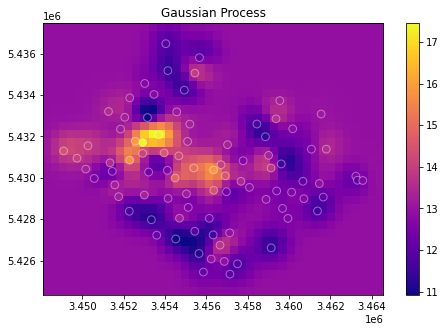

In [5]:
field = gp.predict(X_grid).reshape(grid_x.shape)

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.imshow(field.T, origin='lower', extent=extent, cmap='plasma')
pts = plt.scatter(data.Rechtswert, data.Hochwert, c=data.GWT, s=60, edgecolor='#ffffff66', cmap='plasma')
plt.title('Gaussian Process')
plt.colorbar()
plt.show()

Beurteilt das Ergebnis der Interpolation nun zunächst optisch. Seid Ihr mit der Interpolation zufrieden? Vergleicht das Ergebnis auch mit dem des Kriging von vorhin. 

Für eine genauere Abschätzung wollen wir nun noch die Differenz zwischen den abgeschätzten und gemessenen Werten an den Messpunkten berechnen. Wendet dafür die `Gauß-Objekt.predict()` Funktion auf die Koordinaten der Messstellen an, und plottet die berechnetetn Abweichungen in einem Histogramm. 

Lasst Euch außerdem die Standardabweichung dieser Abweichungen anzeigen (diese entspricht konzeptionell dem RMSE). 

0.16837089253620108


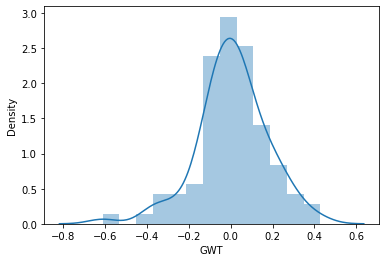

In [6]:
GWT_hat = gp.predict(data[['Rechtswert', 'Hochwert']].values)
rmse = np.std(GWT_hat - data.GWT)
print(rmse)

import seaborn as sns
sns.distplot(GWT_hat - data.GWT)
plt.show()

Wie würdet Ihr den Fehler in der Anpassung bewerten? 

Das Ergebnis der Interpolation mit Gauß-Prozessen kann sehr einfach durch Änderung der Kovarianz-Funktion angepasst, bzw. manipuliert werden. Wir können zum Beispiel noch einen expliziten Term für die Berücksichtigung von möglichen Messfehlern einbauen. 

Erstellt dafür einen zweiten Kernel in dem Ihr zu dem Kernel oben einen "WhiteKernel()" mit dem Input "noise_level=1e-4" addiert. Dann führt die Definition des Gauß-Prozess Objektes und Anpassung analog zu oben durch. Lasst Euch von `gp.predict()` auch die Unsicherheit in der Vorhersage ausgeben, in dem Ihr als zusätzliches Argument "return_std=True" angebt, und einen zweiten Output (z.B. "sigma") definiert. 

In [7]:
from sklearn.gaussian_process.kernels import WhiteKernel
kernel2 = ConstantKernel(constant_value=1e2) * RBF(length_scale=150) + WhiteKernel(noise_level=1e-4)

gp = GaussianProcessRegressor(normalize_y=True, alpha=0.1, kernel=kernel2)

gp.fit(data[['Rechtswert', 'Hochwert']].values, data.GWT.values)
field, sigma = gp.predict(X_grid, return_std=True)

Visualisiert nun erneut die Ergebnisse für die interpolierte Temperatur und den Fehler (die Standardabweichung) in der Interpolation in einer gemeinsamen Abbildung. Denkt daran, zunächst die Dimensionen der Arrays anzupassen, wenn Ihr "matplotlib.pyplot.imshow()" verwendet. 

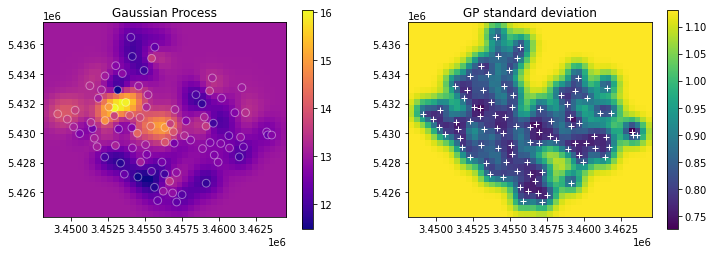

In [10]:
field = field.reshape(grid_x.shape)
sigma = sigma.reshape(grid_x.shape)

fig = plt.figure(1, figsize=(12, 6))
ax = fig.add_subplot(1,2,1)
art = ax.imshow(field.T, origin='lower', extent=extent, cmap='plasma')
pts = plt.scatter(data.Rechtswert, data.Hochwert, c=data.GWT, s=60, edgecolor='#ffffff66', cmap='plasma')
ax.set_title('Gaussian Process')
plt.colorbar(art, shrink=0.67)

ax1 = fig.add_subplot(1,2,2)
art2 = ax1.imshow(sigma.T, origin='lower', extent=extent, cmap='viridis')
ax1.plot(data.Rechtswert, data.Hochwert, '+w')
ax1.set_title('GP standard deviation')
plt.colorbar(art2, shrink=0.67)
plt.show()

Berechnet nun wie oben wieder die Abweichung zwischen Messwerten und interpolierten Werten an den Stützpunkten (Messstellen). 

0.26565910747060023


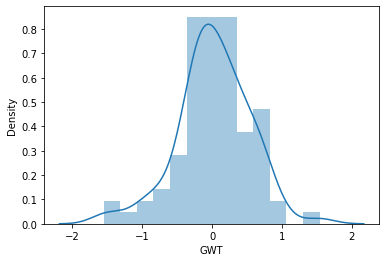

In [11]:
GWT_hat = gp.predict(data[['Rechtswert', 'Hochwert']].values)
rmse = np.var(GWT_hat - data.GWT)
print(rmse)

import seaborn as sns
sns.distplot(GWT_hat - data.GWT)
plt.show()

Wie verhält sich die Abweichung im Vergleich zu der Anpassung ohne Berücksichtigung von Messfehlern, bzw. der Messgenauigkeit? 

Wenn ncoh Zeit könnt Ihr noch z.B. die Startwerte für die Hyperparameter (magnitude, lengthscale, noise level) ändern und beobachten wie sich das auf das Interpolationsergebnis auswirkt. 

## Ende

### Referenzen

Menberg et al. (2013): Long-term evolution of anthropogenic heat fluxes into a subsurface urban heat island, Environ. Sci. Technol. 47(17) (2013) 9747-9755

https://colab.research.google.com/github/agile-geoscience/xlines/blob/master/notebooks/11_Gridding_map_data.ipynb